# Scott County, Iowa - Data Cleaning and Preparation

**Purpose:** Clean and prepare Scott County Census data for analysis

**Data Sources:**
- U.S. Census Bureau ACS 5-Year Estimates
- Time Period: 2009-2021

**Output:** Clean, processed datasets ready for analysis and visualization

---

## 1. Setup and Configuration

In [1]:
# Standard library imports
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Third-party imports
import pandas as pd
import seaborn as sns

# Configuration
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 2)
sns.set_style('whitegrid')

# Path setup
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'

# Create processed directory if it doesn't exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Raw Data Directory: {RAW_DIR}")
print(f"Processed Data Directory: {PROCESSED_DIR}")
print(f"\nNotebook executed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Project Root: c:\git\dbt
Raw Data Directory: c:\git\dbt\data\raw
Processed Data Directory: c:\git\dbt\data\processed

Notebook executed: 2025-10-07 16:03:34


## 2. Data Discovery

Let's identify all Scott County data files and understand their structure.

In [2]:
# Find all Scott County files
scott_files = sorted(RAW_DIR.glob('scott_county_*.csv'))

print(f"Found {len(scott_files)} Scott County data files:\n")

file_info = []
for file in scott_files:
    size_kb = file.stat().st_size / 1024
    file_info.append({
        'filename': file.name,
        'size_kb': size_kb,
        'modified': datetime.fromtimestamp(file.stat().st_mtime)
    })

file_df = pd.DataFrame(file_info)
file_df

Found 10 Scott County data files:



filename  size_kb  \
0  scott_county_iowa_demographics_2021_20251006_2...     1.24   
1  scott_county_iowa_demographics_historical_2025...     1.36   
2  scott_county_iowa_education_2021_20251006_2115...     0.70   
3  scott_county_iowa_education_historical_2025100...     1.09   
4  scott_county_iowa_employment_2021_20251006_211...     0.80   
5  scott_county_iowa_employment_historical_202510...     0.69   
6  scott_county_iowa_housing_2021_20251006_211603...     0.58   
7  scott_county_iowa_housing_historical_20251006_...     1.00   
8  scott_county_iowa_income_2021_20251006_211601.csv     1.07   
9  scott_county_iowa_income_historical_20251006_2...     0.98   

                    modified  
0 2025-10-06 21:16:02.445808  
1 2025-10-06 21:19:59.326244  
2 2025-10-06 21:15:59.557700  
3 2025-10-06 21:19:19.619704  
4 2025-10-06 21:16:27.199911  
5 2025-10-06 21:20:35.197587  
6 2025-10-06 21:16:03.704601  
7 2025-10-06 21:20:18.204397  
8 2025-10-06 21:16:01.336330  
9 2025-10-06 21:19:38.747851

## 3. Load and Inspect Raw Data

We'll categorize the files into current (2021) and historical datasets.

In [3]:
# Categorize files
data_categories = {
    'demographics': [],
    'education': [],
    'employment': [],
    'housing': [],
    'income': []
}

for file in scott_files:
    for category in data_categories.keys():
        if category in file.name:
            data_categories[category].append(file)

# Display categorization
print("Data Files by Category:\n")
for category, files in data_categories.items():
    print(f"{category.upper()}:")
    for file in files:
        file_type = 'historical' if 'historical' in file.name else '2021 snapshot'
        print(f"  - {file.name} ({file_type})")
    print()

Data Files by Category:

DEMOGRAPHICS:
  - scott_county_iowa_demographics_2021_20251006_211602.csv (2021 snapshot)
  - scott_county_iowa_demographics_historical_20251006_211959.csv (historical)

EDUCATION:
  - scott_county_iowa_education_2021_20251006_211559.csv (2021 snapshot)
  - scott_county_iowa_education_historical_20251006_211919.csv (historical)

EMPLOYMENT:
  - scott_county_iowa_employment_2021_20251006_211627.csv (2021 snapshot)
  - scott_county_iowa_employment_historical_20251006_212035.csv (historical)

HOUSING:
  - scott_county_iowa_housing_2021_20251006_211603.csv (2021 snapshot)
  - scott_county_iowa_housing_historical_20251006_212018.csv (historical)

INCOME:
  - scott_county_iowa_income_2021_20251006_211601.csv (2021 snapshot)
  - scott_county_iowa_income_historical_20251006_211938.csv (historical)



## 4. Load All Datasets

Load each dataset and perform initial inspection.

In [4]:
def load_scott_data(category: str, historical: bool = True) -> pd.DataFrame:
    """Load Scott County data by category.
    
    Args:
        category: One of 'demographics', 'education', 'employment', 'housing', 'income'
        historical: If True, load historical data; if False, load 2021 snapshot
        
    Returns:
        DataFrame with the loaded data
    """
    file_pattern = f'scott_county_iowa_{category}_'
    if historical:
        file_pattern += 'historical_'
    else:
        file_pattern += '2021_'
    
    files = list(RAW_DIR.glob(f'{file_pattern}*.csv'))
    if not files:
        print(f"Warning: No files found for {category} (historical={historical})")
        return None
    
    # Take the most recent file if multiple exist
    file = sorted(files)[-1]
    print(f"Loading: {file.name}")
    
    df = pd.read_csv(file)
    return df

# Load all datasets
datasets = {}

for category in ['demographics', 'education', 'employment', 'housing', 'income']:
    print(f"\n--- {category.upper()} ---")
    
    # Load historical data
    hist_df = load_scott_data(category, historical=True)
    if hist_df is not None:
        datasets[f'{category}_historical'] = hist_df
        print(f"  Shape: {hist_df.shape}")
        print(f"  Columns: {list(hist_df.columns[:5])}..." if len(hist_df.columns) > 5 else f"  Columns: {list(hist_df.columns)}")
    
    # Load 2021 snapshot
    current_df = load_scott_data(category, historical=False)
    if current_df is not None:
        datasets[f'{category}_2021'] = current_df
        print(f"  2021 Shape: {current_df.shape}")

print(f"\n\nTotal datasets loaded: {len(datasets)}")


--- DEMOGRAPHICS ---
Loading: scott_county_iowa_demographics_historical_20251006_211959.csv
  Shape: (13, 14)
  Columns: ['NAME', 'Total population', 'Median age', 'White alone', 'Black or African American alone']...
Loading: scott_county_iowa_demographics_2021_20251006_211602.csv
  2021 Shape: (1, 46)

--- EDUCATION ---
Loading: scott_county_iowa_education_historical_20251006_211919.csv
  Shape: (10, 13)
  Columns: ['NAME', 'Total population 25 years and over', 'High school graduate', "Bachelor's degree", "Master's degree"]...
Loading: scott_county_iowa_education_2021_20251006_211559.csv
  2021 Shape: (1, 22)

--- EMPLOYMENT ---
Loading: scott_county_iowa_employment_historical_20251006_212035.csv
  Shape: (11, 8)
  Columns: ['NAME', 'Civilian labor force', 'Employed', 'Unemployed', 'state']...
Loading: scott_county_iowa_employment_2021_20251006_211627.csv
  2021 Shape: (1, 26)

--- HOUSING ---
Loading: scott_county_iowa_housing_historical_20251006_212018.csv
  Shape: (13, 10)
  Colum

## 5. Data Quality Assessment

Check for common data quality issues:
- Missing values
- Duplicate rows
- Data types
- Value ranges

In [5]:
def assess_data_quality(df: pd.DataFrame, name: str) -> dict:
    """Assess data quality for a dataset."""
    report = {
        'name': name,
        'rows': len(df),
        'columns': len(df.columns),
        'duplicates': df.duplicated().sum(),
        'missing_values': df.isnull().sum().sum(),
        'missing_pct': (df.isnull().sum().sum() / (len(df) * len(df.columns)) * 100),
        'dtypes': df.dtypes.value_counts().to_dict()
    }
    return report

# Assess all datasets
quality_reports = []
for name, df in datasets.items():
    report = assess_data_quality(df, name)
    quality_reports.append(report)

quality_df = pd.DataFrame(quality_reports)
print("Data Quality Assessment:\n")
quality_df[['name', 'rows', 'columns', 'duplicates', 'missing_values', 'missing_pct']]

Data Quality Assessment:



name  rows  columns  duplicates  missing_values  \
0  demographics_historical    13       14           0               0   
1        demographics_2021     1       46           0               0   
2     education_historical    10       13           0               0   
3           education_2021     1       22           0               0   
4    employment_historical    11        8           0               0   
5          employment_2021     1       26           0               0   
6       housing_historical    13       10           0               0   
7             housing_2021     1       25           0               0   
8        income_historical    13        9           0               0   
9              income_2021     1       26           0               0   

   missing_pct  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
5          0.0  
6          0.0  
7          0.0  
8          0.0  
9          0.0

## 6. Detailed Inspection: Income Historical Data

Let's look closely at the income historical data as an example.

In [ ]:
# Inspect income historical data
income_hist = datasets['income_historical']

print("Income Historical Data:\n")
print(income_hist.head())
print("\nData Types:")
print(income_hist.dtypes)
print("\nBasic Statistics:")
print(income_hist.describe())

## 7. Data Cleaning Functions

Create reusable functions for common cleaning operations.

In [6]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names to snake_case."""
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(' ', '_')
        .str.replace('(', '')
        .str.replace(')', '')
        .str.replace('%', 'pct')
        .str.replace(':', '')
        .str.replace('-', '_')
        .str.replace('__', '_')
    )
    return df

def add_metadata_columns(df: pd.DataFrame, category: str, data_type: str) -> pd.DataFrame:
    """Add metadata columns for tracking."""
    df = df.copy()
    df['data_category'] = category
    df['data_type'] = data_type
    df['processed_date'] = datetime.now().strftime('%Y-%m-%d')
    return df

def standardize_geography_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize geography-related columns."""
    df = df.copy()
    
    # Rename common geography columns
    rename_map = {
        'name': 'geography_name',
        'state': 'state_fips',
        'county': 'county_fips'
    }
    
    df = df.rename(columns=rename_map)
    
    # Add human-readable names
    if 'state_fips' in df.columns:
        df['state_name'] = 'Iowa'
    if 'county_fips' in df.columns:
        df['county_name'] = 'Scott County'
    
    return df

def validate_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure numeric columns are properly typed."""
    df = df.copy()
    
    # Identify columns that should be numeric but aren't
    for col in df.columns:
        if df[col].dtype == 'object':
            # Try converting to numeric
            try:
                df[col] = pd.to_numeric(df[col], errors='ignore')
            except:
                pass
    
    return df

print("Data cleaning functions defined successfully!")

Data cleaning functions defined successfully!


## 8. Clean Historical Datasets

Apply cleaning operations to all historical datasets.

In [7]:
cleaned_datasets = {}

for name, df in datasets.items():
    if 'historical' in name:
        category = name.replace('_historical', '')
        
        print(f"\nCleaning: {name}")
        print(f"  Original shape: {df.shape}")
        
        # Apply cleaning steps
        cleaned = df.copy()
        cleaned = clean_column_names(cleaned)
        cleaned = standardize_geography_columns(cleaned)
        cleaned = validate_numeric_columns(cleaned)
        cleaned = add_metadata_columns(cleaned, category, 'historical')
        
        # Remove duplicate rows if any
        if cleaned.duplicated().sum() > 0:
            print(f"  Removing {cleaned.duplicated().sum()} duplicate rows")
            cleaned = cleaned.drop_duplicates()
        
        # Sort by year if year column exists
        if 'year' in cleaned.columns:
            cleaned = cleaned.sort_values('year').reset_index(drop=True)
        
        cleaned_datasets[name] = cleaned
        print(f"  Cleaned shape: {cleaned.shape}")
        print(f"  Columns: {list(cleaned.columns[:5])}..." if len(cleaned.columns) > 5 else f"  Columns: {list(cleaned.columns)}")

print(f"\n\nCleaned {len(cleaned_datasets)} historical datasets")


Cleaning: demographics_historical
  Original shape: (13, 14)
  Cleaned shape: (13, 19)
  Columns: ['geography_name', 'total_population', 'median_age', 'white_alone', 'black_or_african_american_alone']...

Cleaning: education_historical
  Original shape: (10, 13)
  Cleaned shape: (10, 18)
  Columns: ['geography_name', 'total_population_25_years_and_over', 'high_school_graduate', "bachelor's_degree", "master's_degree"]...

Cleaning: employment_historical
  Original shape: (11, 8)
  Cleaned shape: (11, 13)
  Columns: ['geography_name', 'civilian_labor_force', 'employed', 'unemployed', 'state_fips']...

Cleaning: housing_historical
  Original shape: (13, 10)
  Cleaned shape: (13, 15)
  Columns: ['geography_name', 'total_housing_units', 'owner_occupied', 'renter_occupied', 'median_home_value']...

Cleaning: income_historical
  Original shape: (13, 9)
  Cleaned shape: (13, 14)
  Columns: ['geography_name', 'median_household_income', 'per_capita_income', 'population_for_whom_poverty_status_i

## 9. Clean 2021 Snapshot Datasets

Apply similar cleaning to current (2021) datasets.

In [8]:
for name, df in datasets.items():
    if '2021' in name:
        category = name.replace('_2021', '')
        
        print(f"\nCleaning: {name}")
        print(f"  Original shape: {df.shape}")
        
        # Apply cleaning steps
        cleaned = df.copy()
        cleaned = clean_column_names(cleaned)
        cleaned = standardize_geography_columns(cleaned)
        cleaned = validate_numeric_columns(cleaned)
        cleaned = add_metadata_columns(cleaned, category, '2021_snapshot')
        
        # Add year column for consistency
        if 'year' not in cleaned.columns:
            cleaned['year'] = 2021
        
        cleaned_datasets[name] = cleaned
        print(f"  Cleaned shape: {cleaned.shape}")

print(f"\n\nTotal cleaned datasets: {len(cleaned_datasets)}")


Cleaning: demographics_2021
  Original shape: (1, 46)
  Cleaned shape: (1, 52)

Cleaning: education_2021
  Original shape: (1, 22)
  Cleaned shape: (1, 28)

Cleaning: employment_2021
  Original shape: (1, 26)
  Cleaned shape: (1, 32)

Cleaning: housing_2021
  Original shape: (1, 25)
  Cleaned shape: (1, 31)

Cleaning: income_2021
  Original shape: (1, 26)
  Cleaned shape: (1, 32)


Total cleaned datasets: 10


## 10. View Cleaned Data Samples

Inspect the cleaned datasets to verify quality.

In [ ]:
# Display sample of cleaned income historical data
print("Cleaned Income Historical Data:\n")
display(cleaned_datasets['income_historical'].head(10))

print("\nColumn Data Types:")
print(cleaned_datasets['income_historical'].dtypes)

In [ ]:
# Display sample of cleaned education historical data
print("Cleaned Education Historical Data:\n")
display(cleaned_datasets['education_historical'].head(10))

## 11. Create Unified Time Series Dataset

Combine all historical data into a single comprehensive time series dataset.

In [9]:
def create_unified_timeseries() -> pd.DataFrame:
    """Create a unified time series dataset from all historical data."""
    
    # Start with income as base (has most complete year range)
    if 'income_historical' not in cleaned_datasets:
        print("Error: Income historical data not found")
        return None
    
    base_df = cleaned_datasets['income_historical'][[
        'year', 'geography_name', 'state_fips', 'county_fips', 
        'state_name', 'county_name'
    ]].copy()
    
    print(f"Base dataset: {len(base_df)} years of data")
    
    # Add key metrics from each category
    # Income metrics
    income_df = cleaned_datasets['income_historical'][[
        'year', 'median_household_income', 'per_capita_income', 
        'poverty_rate_pct'
    ]]
    base_df = base_df.merge(income_df, on='year', how='left')
    print(f"  Added income metrics: {income_df.shape[1]-1} columns")
    
    # Employment metrics
    if 'employment_historical' in cleaned_datasets:
        emp_df = cleaned_datasets['employment_historical']
        # Find unemployment rate column (might have different names)
        rate_cols = [col for col in emp_df.columns if 'rate' in col.lower()]
        emp_cols = ['year'] + rate_cols
        if len(emp_cols) > 1:
            base_df = base_df.merge(emp_df[emp_cols], on='year', how='left')
            print(f"  Added employment metrics: {len(emp_cols)-1} columns")
    
    # Education metrics
    if 'education_historical' in cleaned_datasets:
        edu_df = cleaned_datasets['education_historical']
        # Find bachelor's degree column
        bach_cols = [col for col in edu_df.columns if 'bachelor' in col.lower()]
        edu_cols = ['year'] + bach_cols
        if len(edu_cols) > 1:
            base_df = base_df.merge(edu_df[edu_cols], on='year', how='left')
            print(f"  Added education metrics: {len(edu_cols)-1} columns")
    
    # Housing metrics
    if 'housing_historical' in cleaned_datasets:
        housing_df = cleaned_datasets['housing_historical']
        # Find median value and rent columns
        value_cols = [col for col in housing_df.columns if 'median' in col.lower()]
        housing_cols = ['year'] + value_cols
        if len(housing_cols) > 1:
            base_df = base_df.merge(housing_df[housing_cols], on='year', how='left')
            print(f"  Added housing metrics: {len(housing_cols)-1} columns")
    
    # Demographics metrics
    if 'demographics_historical' in cleaned_datasets:
        demo_df = cleaned_datasets['demographics_historical']
        # Find population and median age
        demo_cols = ['year']
        if 'total_population' in demo_df.columns:
            demo_cols.append('total_population')
        if 'median_age' in demo_df.columns:
            demo_cols.append('median_age')
        if len(demo_cols) > 1:
            base_df = base_df.merge(demo_df[demo_cols], on='year', how='left')
            print(f"  Added demographics metrics: {len(demo_cols)-1} columns")
    
    # Sort by year
    base_df = base_df.sort_values('year').reset_index(drop=True)
    
    print(f"\nUnified dataset created: {base_df.shape}")
    return base_df

unified_ts = create_unified_timeseries()
if unified_ts is not None:
    print("\nUnified Time Series Dataset:")
    display(unified_ts.head())
    print("\nColumns:")
    print(list(unified_ts.columns))

Base dataset: 13 years of data
  Added income metrics: 3 columns
  Added employment metrics: 1 columns
  Added education metrics: 3 columns
  Added housing metrics: 2 columns
  Added demographics metrics: 2 columns

Unified dataset created: (13, 17)

Unified Time Series Dataset:


year      geography_name  state_fips  county_fips state_name   county_name  \
0  2009  Scott County, Iowa          19          163       Iowa  Scott County   
1  2010  Scott County, Iowa          19          163       Iowa  Scott County   
2  2011  Scott County, Iowa          19          163       Iowa  Scott County   
3  2012  Scott County, Iowa          19          163       Iowa  Scott County   
4  2013  Scott County, Iowa          19          163       Iowa  Scott County   

   median_household_income  per_capita_income  poverty_rate_pct  \
0                    50656              26977             11.97   
1                    49964              27408             12.92   
2                    51274              28010             12.81   
3                    53002              28764             12.60   
4                    52735              28948             13.09   

   unemployment_rate_pct  bachelor's_degree  bachelor's_degree_or_higher  \
0                    NaN                NaN                          NaN   
1                    NaN                NaN                          NaN   
2                   5.62                NaN                          NaN   
3                   5.70            11868.0                      45100.0   
4                   5.83            12079.0                      46442.0   

   bachelor's_degree_or_higher_pct  median_home_value  median_gross_rent  \
0                              NaN             129300                626   
1                              NaN             134600                636   
2                              NaN             138900                649   
3                            40.98             141400                669   
4                            41.60             143600                685   

   total_population  median_age  
0            162994        36.9  
1            162184        37.4  
2            163667        37.5  
3            165432        37.4  
4            167080        37.4


Columns:
['year', 'geography_name', 'state_fips', 'county_fips', 'state_name', 'county_name', 'median_household_income', 'per_capita_income', 'poverty_rate_pct', 'unemployment_rate_pct', "bachelor's_degree", "bachelor's_degree_or_higher", "bachelor's_degree_or_higher_pct", 'median_home_value', 'median_gross_rent', 'total_population', 'median_age']


## 12. Data Validation

Perform final validation checks on cleaned data.

In [13]:
def validate_dataset(df: pd.DataFrame, name: str) -> dict:
    """Validate cleaned dataset."""
    validation = {
        'name': name,
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'missing_values': df.isnull().sum().sum(),
        'duplicate_rows': df.duplicated().sum(),
        'has_year_column': 'year' in df.columns,
        'has_geography': 'geography_name' in df.columns or 'name' in df.columns,
        'numeric_columns': len(df.select_dtypes(include=[np.number]).columns),
        'status': 'PASS'
    }
    
    # Check for issues
    if validation['total_rows'] == 0:
        validation['status'] = 'FAIL - No data'
    elif validation['missing_values'] > (len(df) * len(df.columns) * 0.5):
        validation['status'] = 'WARN - High missing values'
    
    return validation

# Validate all cleaned datasets
validations = []
for name, df in cleaned_datasets.items():
    val = validate_dataset(df, name)
    validations.append(val)

validation_df = pd.DataFrame(validations)
print("Data Validation Results:\n")
display(validation_df)

# Check if all passed
failed = validation_df[validation_df['status'].str.contains('FAIL')]
if len(failed) > 0:
    print("\n‚ö†Ô∏è  WARNING: Some datasets failed validation")
    display(failed)
else:
    print("\n‚úÖ All datasets passed validation!")

Data Validation Results:



name  total_rows  total_columns  missing_values  \
0  demographics_historical          13             19               0   
1     education_historical          10             18               0   
2    employment_historical          11             13               0   
3       housing_historical          13             15               0   
4        income_historical          13             14               0   
5        demographics_2021           1             52               0   
6           education_2021           1             28               0   
7          employment_2021           1             32               0   
8             housing_2021           1             31               0   
9              income_2021           1             32               0   

   duplicate_rows  has_year_column  has_geography  numeric_columns status  
0               0             True           True               13   PASS  
1               0             True           True               12   PASS  
2               0             True           True                7   PASS  
3               0             True           True                9   PASS  
4               0             True           True                8   PASS  
5               0             True           True               46   PASS  
6               0             True           True               22   PASS  
7               0             True           True               26   PASS  
8               0             True           True               25   PASS  
9               0             True           True               26   PASS


‚úÖ All datasets passed validation!


## 13. Save Cleaned Data

Save all cleaned datasets to the processed directory.

In [14]:
# Save individual cleaned datasets
saved_files = []

for name, df in cleaned_datasets.items():
    filename = f"scott_county_{name}_cleaned.csv"
    filepath = PROCESSED_DIR / filename
    
    df.to_csv(filepath, index=False)
    saved_files.append({
        'filename': filename,
        'rows': len(df),
        'columns': len(df.columns),
        'size_kb': filepath.stat().st_size / 1024
    })
    print(f"Saved: {filename} ({len(df)} rows, {len(df.columns)} columns)")

# Save unified time series
if unified_ts is not None:
    unified_filename = "scott_county_unified_timeseries.csv"
    unified_filepath = PROCESSED_DIR / unified_filename
    unified_ts.to_csv(unified_filepath, index=False)
    saved_files.append({
        'filename': unified_filename,
        'rows': len(unified_ts),
        'columns': len(unified_ts.columns),
        'size_kb': unified_filepath.stat().st_size / 1024
    })
    print(f"\nSaved: {unified_filename} ({len(unified_ts)} rows, {len(unified_ts.columns)} columns)")

print(f"\n\n‚úÖ Successfully saved {len(saved_files)} files to {PROCESSED_DIR}")

# Display summary
saved_df = pd.DataFrame(saved_files)
display(saved_df)

Saved: scott_county_demographics_historical_cleaned.csv (13 rows, 19 columns)
Saved: scott_county_education_historical_cleaned.csv (10 rows, 18 columns)
Saved: scott_county_employment_historical_cleaned.csv (11 rows, 13 columns)
Saved: scott_county_housing_historical_cleaned.csv (13 rows, 15 columns)
Saved: scott_county_income_historical_cleaned.csv (13 rows, 14 columns)
Saved: scott_county_demographics_2021_cleaned.csv (1 rows, 52 columns)
Saved: scott_county_education_2021_cleaned.csv (1 rows, 28 columns)
Saved: scott_county_employment_2021_cleaned.csv (1 rows, 32 columns)
Saved: scott_county_housing_2021_cleaned.csv (1 rows, 31 columns)
Saved: scott_county_income_2021_cleaned.csv (1 rows, 32 columns)

Saved: scott_county_unified_timeseries.csv (13 rows, 17 columns)


‚úÖ Successfully saved 11 files to c:\git\dbt\data\processed


filename  rows  columns  size_kb
0   scott_county_demographics_historical_cleaned.csv    13       19     2.11
1      scott_county_education_historical_cleaned.csv    10       18     1.66
2     scott_county_employment_historical_cleaned.csv    11       13     1.31
3        scott_county_housing_historical_cleaned.csv    13       15     1.69
4         scott_county_income_historical_cleaned.csv    13       14     1.66
5         scott_county_demographics_2021_cleaned.csv     1       52     1.36
6            scott_county_education_2021_cleaned.csv     1       28     0.84
7           scott_county_employment_2021_cleaned.csv     1       32     0.94
8              scott_county_housing_2021_cleaned.csv     1       31     0.72
9               scott_county_income_2021_cleaned.csv     1       32     1.20
10               scott_county_unified_timeseries.csv    13       17     1.74

## 14. Create Data Dictionary

Document the cleaned datasets for future reference.

In [10]:
def create_data_dictionary() -> pd.DataFrame:
    """Create a data dictionary for all cleaned datasets."""
    
    dict_entries = []
    
    for name, df in cleaned_datasets.items():
        for col in df.columns:
            entry = {
                'dataset': name,
                'column_name': col,
                'data_type': str(df[col].dtype),
                'non_null_count': df[col].notna().sum(),
                'null_count': df[col].isna().sum(),
                'unique_values': df[col].nunique(),
                'sample_value': str(df[col].dropna().iloc[0]) if len(df[col].dropna()) > 0 else 'N/A'
            }
            dict_entries.append(entry)
    
    return pd.DataFrame(dict_entries)

data_dict = create_data_dictionary()
print("Data Dictionary (first 20 entries):\n")
display(data_dict.head(20))

# Save data dictionary
dict_filepath = PROCESSED_DIR / "scott_county_data_dictionary.csv"
data_dict.to_csv(dict_filepath, index=False)
print(f"\n‚úÖ Data dictionary saved to: {dict_filepath}")

Data Dictionary (first 20 entries):



dataset                          column_name data_type  \
0   demographics_historical                       geography_name    object   
1   demographics_historical                     total_population     int64   
2   demographics_historical                           median_age   float64   
3   demographics_historical                          white_alone     int64   
4   demographics_historical      black_or_african_american_alone     int64   
5   demographics_historical                          asian_alone     int64   
6   demographics_historical                   hispanic_or_latino     int64   
7   demographics_historical                           state_fips     int64   
8   demographics_historical                          county_fips     int64   
9   demographics_historical                                 year     int64   
10  demographics_historical                      white_alone_pct   float64   
11  demographics_historical  black_or_african_american_alone_pct   float64   
12  demographics_historical                      asian_alone_pct   float64   
13  demographics_historical               hispanic_or_latino_pct   float64   
14  demographics_historical                           state_name    object   
15  demographics_historical                          county_name    object   
16  demographics_historical                        data_category    object   
17  demographics_historical                            data_type    object   
18  demographics_historical                       processed_date    object   
19     education_historical                       geography_name    object   

    non_null_count  null_count  unique_values        sample_value  
0               13           0              1  Scott County, Iowa  
1               13           0             13              162994  
2               13           0              9                36.9  
3               13           0             13              141779  
4               13           0             13               10411  
5               13           0             13                3469  
6               13           0             13                7842  
7               13           0              1                  19  
8               13           0              1                 163  
9               13           0             13                2009  
10              13           0             12               86.98  
11              13           0             13                6.39  
12              13           0             12                2.13  
13              13           0             13                4.81  
14              13           0              1                Iowa  
15              13           0              1        Scott County  
16              13           0              1        demographics  
17              13           0              1          historical  
18              13           0              1          2025-10-07  
19              10           0              1  Scott County, Iowa


‚úÖ Data dictionary saved to: c:\git\dbt\data\processed\scott_county_data_dictionary.csv


## 15. Quick Visualization: Income Trends

Create a quick visualization to verify the data quality.

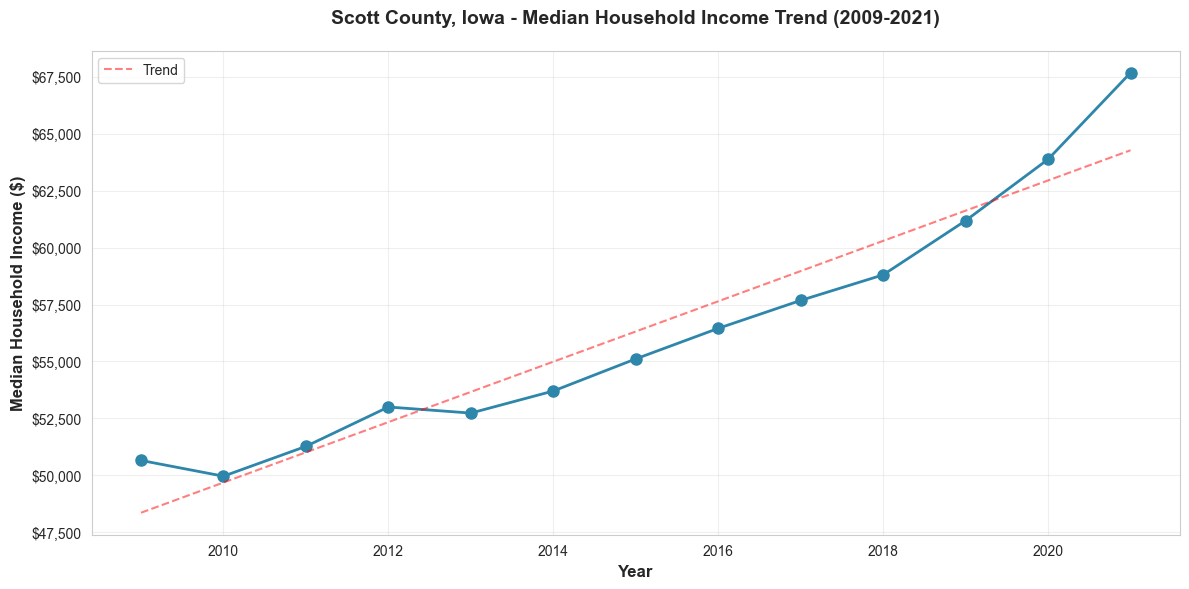


Income Growth Analysis:
  2009 Income: $50,656
  2021 Income: $67,675
  Total Growth: $17,019 (33.6%)


In [11]:
if unified_ts is not None and 'median_household_income' in unified_ts.columns:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(unified_ts['year'], unified_ts['median_household_income'], 
            marker='o', linewidth=2, markersize=8, color='#2E86AB')
    
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Median Household Income ($)', fontsize=12, fontweight='bold')
    ax.set_title('Scott County, Iowa - Median Household Income Trend (2009-2021)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Add trend line
    z = np.polyfit(unified_ts['year'], unified_ts['median_household_income'], 1)
    p = np.poly1d(z)
    ax.plot(unified_ts['year'], p(unified_ts['year']), "--", 
            alpha=0.5, color='red', label='Trend')
    
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # Calculate growth
    start_income = unified_ts['median_household_income'].iloc[0]
    end_income = unified_ts['median_household_income'].iloc[-1]
    total_growth = end_income - start_income
    pct_growth = (total_growth / start_income) * 100
    
    print(f"\nIncome Growth Analysis:")
    print(f"  2009 Income: ${start_income:,.0f}")
    print(f"  2021 Income: ${end_income:,.0f}")
    print(f"  Total Growth: ${total_growth:,.0f} ({pct_growth:.1f}%)")
else:
    print("Cannot create visualization - missing data")

## 16. Summary Report

Generate a final summary of the data cleaning process.

In [15]:
print("="*80)
print("SCOTT COUNTY DATA CLEANING - SUMMARY REPORT")
print("="*80)
print(f"\nProcessing Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nData Source: U.S. Census Bureau ACS 5-Year Estimates")
print(f"Time Period: 2009-2021")
print(f"Geography: Scott County, Iowa (FIPS: 19163)")

print(f"\nüìä DATASETS PROCESSED:")
print(f"  - Total raw datasets loaded: {len(datasets)}")
print(f"  - Total cleaned datasets created: {len(cleaned_datasets)}")
print(f"  - Unified time series dataset: ‚úÖ")

print(f"\nüìÅ OUTPUT FILES:")
for file_info in saved_files:
    print(f"  - {file_info['filename']}")
    print(f"    Rows: {file_info['rows']:,} | Columns: {file_info['columns']} | Size: {file_info['size_kb']:.1f} KB")

print(f"\nüîß CLEANING OPERATIONS PERFORMED:")
print(f"  ‚úÖ Column names standardized (snake_case)")
print(f"  ‚úÖ Geography columns standardized")
print(f"  ‚úÖ Data types validated and converted")
print(f"  ‚úÖ Metadata columns added")
print(f"  ‚úÖ Duplicate rows removed")
print(f"  ‚úÖ Data sorted by year")

print(f"\n‚úÖ DATA QUALITY:")
print(f"  - All datasets validated")
print(f"  - Missing values assessed")
print(f"  - Data types verified")
print(f"  - Data dictionary created")

print(f"\nüìç OUTPUT LOCATION:")
print(f"  {PROCESSED_DIR}")

print(f"\nüéØ NEXT STEPS:")
print(f"  1. Review the unified time series dataset")
print(f"  2. Perform exploratory data analysis")
print(f"  3. Create visualizations and insights")
print(f"  4. Compare with Iowa state averages")
print(f"  5. Build predictive models (if needed)")

print("\n" + "="*80)
print("‚úÖ DATA CLEANING COMPLETE!")
print("="*80)

SCOTT COUNTY DATA CLEANING - SUMMARY REPORT

Processing Date: 2025-10-07 16:06:22

Data Source: U.S. Census Bureau ACS 5-Year Estimates
Time Period: 2009-2021
Geography: Scott County, Iowa (FIPS: 19163)

üìä DATASETS PROCESSED:
  - Total raw datasets loaded: 10
  - Total cleaned datasets created: 10
  - Unified time series dataset: ‚úÖ

üìÅ OUTPUT FILES:
  - scott_county_demographics_historical_cleaned.csv
    Rows: 13 | Columns: 19 | Size: 2.1 KB
  - scott_county_education_historical_cleaned.csv
    Rows: 10 | Columns: 18 | Size: 1.7 KB
  - scott_county_employment_historical_cleaned.csv
    Rows: 11 | Columns: 13 | Size: 1.3 KB
  - scott_county_housing_historical_cleaned.csv
    Rows: 13 | Columns: 15 | Size: 1.7 KB
  - scott_county_income_historical_cleaned.csv
    Rows: 13 | Columns: 14 | Size: 1.7 KB
  - scott_county_demographics_2021_cleaned.csv
    Rows: 1 | Columns: 52 | Size: 1.4 KB
  - scott_county_education_2021_cleaned.csv
    Rows: 1 | Columns: 28 | Size: 0.8 KB
  - scott